In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_day = str(session.query(Measurement.date).order_by(Measurement.date.desc()).first())
print(f"Date of most recent data point: {last_day}")

Date of most recent data point: ('2017-08-23',)


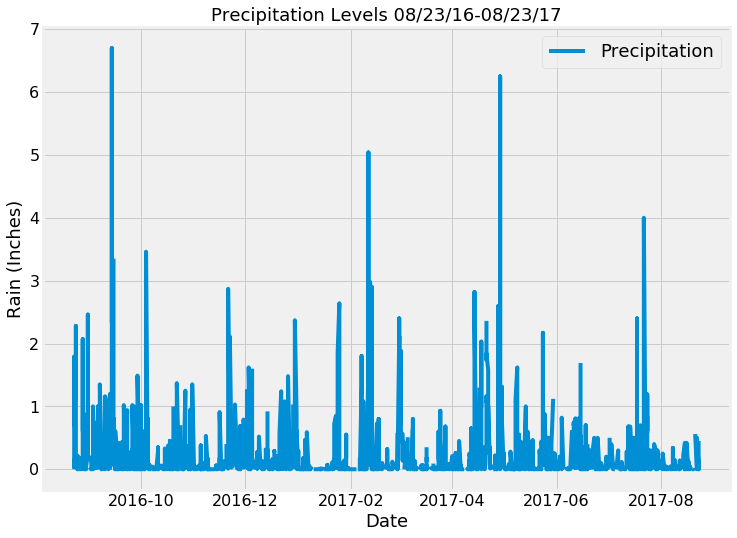

In [11]:
one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precipitation_data)
precipitation_df = precipitation_df.set_index('date')

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(["date"], ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
dates = [pd.to_datetime(d) for d in precipitation_df.index]

plt.plot(dates, precipitation_df["prcp"])

plt.xlabel("Date", fontsize=18)
plt.ylabel("Rain (Inches)", fontsize=18)

plt.title("Precipitation Levels 08/23/16-08/23/17", fontsize=18)
plt.legend(["Precipitation"], loc='best', fontsize=18)

plt.xticks(fontsize=16, visible=True)
plt.yticks(fontsize=16, visible=True)

plt.tight_layout()

figure = plt.gcf()
figure.set_size_inches(11, 9)
plt.grid(visible=True)
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Measurement).group_by(Measurement.station).count()
print("{} stations".format(stations))

9 stations


In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
busiest_stations = session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).all()

for x in range(5):
    print(busiest_stations[x])

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)


In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature for the most active station?

busiest_station = busiest_stations[0][0]

busiest_temp = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.station == busiest_station).order_by(Measurement.date).all()

temp_results = pd.DataFrame(busiest_temp)

lowest_temp_recorded = temp_results["tobs"].min()
highest_temp_recorded = temp_results["tobs"].max()
average_temp = temp_results["tobs"].mean()

print("Temperature data for busiest station:")
print("----------------------------------------")
print(f"lowest temperature recorded: {lowest_temp_recorded}\xb0")
print(f"highest temperature recorded: {highest_temp_recorded}\xb0")
print(f"average temperature: {average_temp}\xb0")

Temperature data for busiest station:
----------------------------------------
lowest temperature recorded: 54.0°
highest temperature recorded: 85.0°
average temperature: 71.66378066378067°


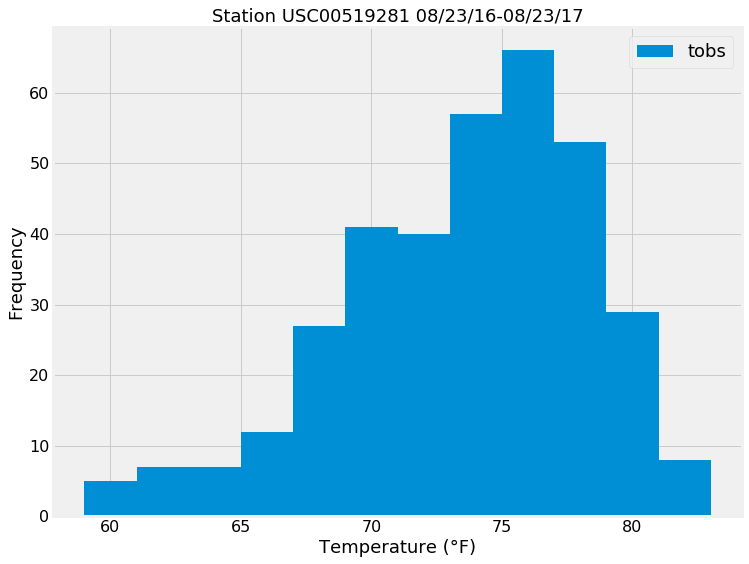

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
busiest_temp_one_year = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.station == busiest_station).order_by(Measurement.date).\
    filter(Measurement.date >= one_year_ago).all()

temp_results_one_year = pd.DataFrame(busiest_temp_one_year)
plt.hist(temp_results_one_year['tobs'], bins=12)
plt.xlabel("Temperature (\xb0F)", fontsize=18)
plt.ylabel("Frequency", fontsize=18)

plt.title("Station " + busiest_station + " 08/23/16-08/23/17", fontsize=18)
plt.legend(["tobs"], loc='best', fontsize=18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

figure = plt.gcf()
figure.set_size_inches(11, 9)
plt.grid(visible=True)
plt.show()

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_first_day = "2017-05-01"
trip_final_day = "2017-05-09"

calc_temp_results = calc_temps(trip_first_day, trip_final_day)
print(calc_temp_results)

[(65.0, 75.11764705882354, 80.0)]


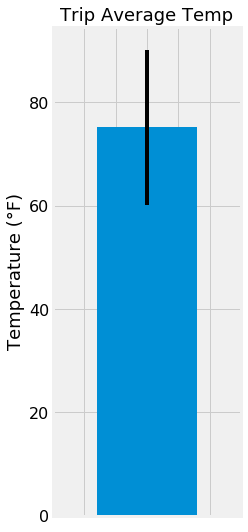

In [35]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

average_temp = calc_temp_results[0][1]

tmax = calc_temp_results[0][2]
tmin = calc_temp_results[0][0]

plt.bar(1, average_temp, yerr=(tmax-tmin))
plt.ylabel("Temperature (\xb0F)", fontsize=18)
plt.title("Trip Average Temp", fontsize=18)

plt.xticks(visible=False)
plt.yticks(fontsize=16)

plt.xlim(0.25,1.75)

figure = plt.gcf()
figure.set_size_inches(3, 9)
plt.show()